Click on the center of each book. Press ESC when done.


2025-04-01 15:13:25.376 python[70721:5982319] +[IMKClient subclass]: chose IMKClient_Modern
2025-04-01 15:13:25.376 python[70721:5982319] +[IMKInputSession subclass]: chose IMKInputSession_Modern


You selected 8 book points.


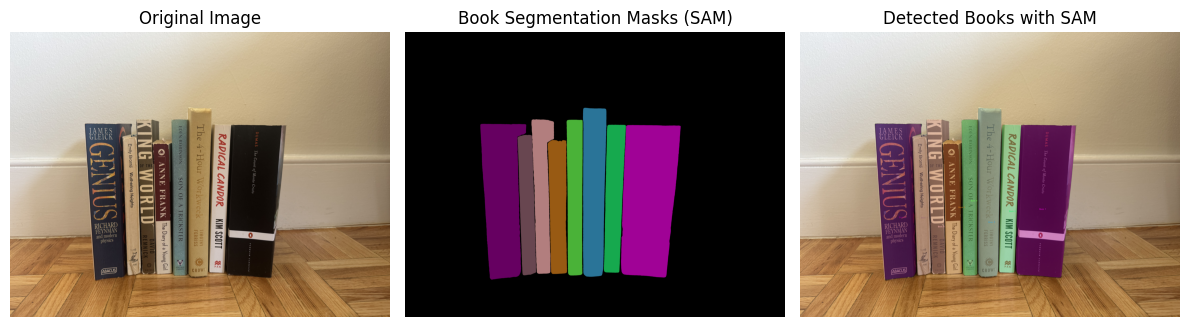

Number of books detected with SAM: 8


In [7]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
from segment_anything import sam_model_registry, SamPredictor

# Load the image
img = cv2.imread('bookshelf.jpg')  # Replace with your actual image path
rgb_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Load the SAM model
sam_checkpoint = "Sam Vit H.pth"  # Replace with your downloaded SAM model path
model_type = "vit_h"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)
predictor = SamPredictor(sam)

# Set the image for the predictor
predictor.set_image(rgb_img)

# Create a function to handle mouse clicks
book_points = []

def click_event(event, x, y, flags, param):
    if event == cv2.EVENT_LBUTTONDOWN:
        book_points.append([x, y])
        # Draw a circle at the clicked point
        cv2.circle(display_img, (x, y), 5, (0, 255, 0), -1)
        cv2.putText(display_img, f"Book {len(book_points)}", (x+10, y), 
                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
        cv2.imshow('Click on book centers (Press ESC when done)', display_img)

# Create a copy of the image for display
display_img = rgb_img.copy()

# Set up the window and mouse callback
cv2.namedWindow('Click on book centers (Press ESC when done)')
cv2.setMouseCallback('Click on book centers (Press ESC when done)', click_event)

# Display instructions
print("Click on the center of each book. Press ESC when done.")
cv2.imshow('Click on book centers (Press ESC when done)', display_img)

# Wait for user to finish clicking
while True:
    key = cv2.waitKey(1) & 0xFF
    if key == 27:  # ESC key
        break

cv2.destroyAllWindows()

print(f"You selected {len(book_points)} book points.")

# Use SAM to generate masks for each book point
masks = []
scores = []
book_masks = []

for point in book_points:
    # Convert point to the format expected by SAM
    input_point = np.array([point])
    input_label = np.array([1])  # 1 indicates foreground
    
    # Generate masks
    mask_predictions, mask_scores, _ = predictor.predict(
        point_coords=input_point,
        point_labels=input_label,
        multimask_output=True
    )
    
    # Get the highest scoring mask
    best_mask_idx = np.argmax(mask_scores)
    masks.append(mask_predictions[best_mask_idx])
    scores.append(mask_scores[best_mask_idx])
    
    # Convert to uint8 for visualization
    mask_uint8 = (mask_predictions[best_mask_idx] * 255).astype(np.uint8)
    book_masks.append(mask_uint8)

# Create a visualization of the detected books
img_with_books = rgb_img.copy()
segmentation_mask = np.zeros((rgb_img.shape[0], rgb_img.shape[1], 3), dtype=np.uint8)

# Draw each mask with a unique color
for i, mask in enumerate(masks):
    # Generate a random color
    color = [np.random.randint(0, 255) for _ in range(3)]
    
    # Apply the mask to the image
    img_with_books[mask] = img_with_books[mask] * 0.7 + np.array(color) * 0.3
    
    # Add to segmentation mask
    colored_mask = np.zeros_like(segmentation_mask)
    colored_mask[mask] = color
    segmentation_mask = cv2.addWeighted(segmentation_mask, 1, colored_mask, 0.7, 0)
    
    # Add book number near the point
    x, y = book_points[i]
    cv2.putText(img_with_books, f"Book {i+1}", (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, color, 2)

# Visualize the results
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(rgb_img)
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(segmentation_mask)
plt.title('Book Segmentation Masks (SAM)')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(img_with_books)
plt.title('Detected Books with SAM')
plt.axis('off')

plt.tight_layout()
plt.show()

print(f"Number of books detected with SAM: {len(masks)}")


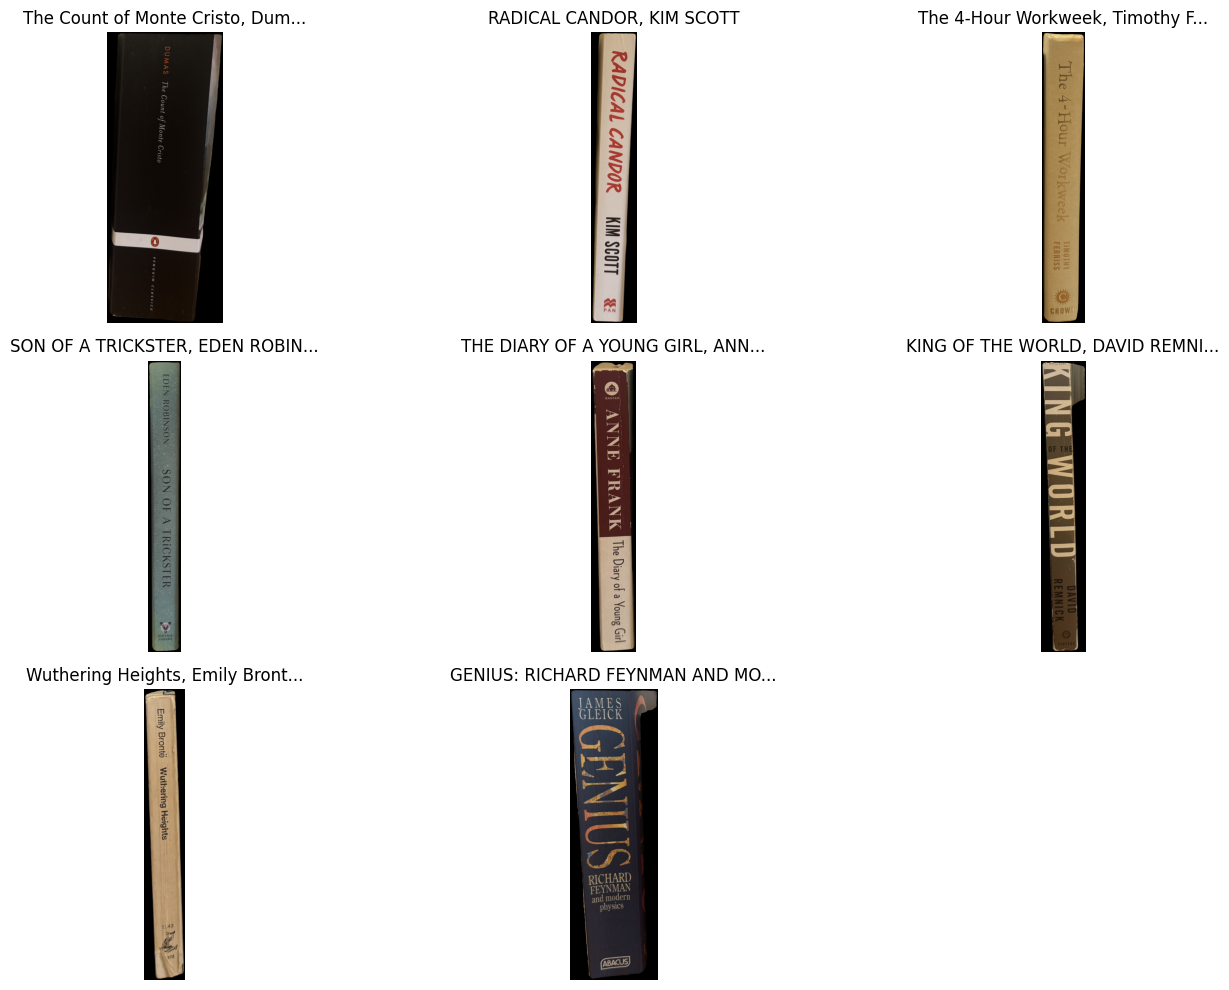

Detected Books:
The Count of Monte Cristo, Dumas
RADICAL CANDOR, KIM SCOTT
The 4-Hour Workweek, Timothy Ferriss
SON OF A TRICKSTER, EDEN ROBINSON
THE DIARY OF A YOUNG GIRL, ANNE FRANK
KING OF THE WORLD, DAVID REMNICK
Wuthering Heights, Emily Brontë
GENIUS: RICHARD FEYNMAN AND MODERN PHYSICS, JAMES GLEICK


In [17]:
# Book recognition using Multi-Modal LLMs

# Import necessary libraries
import cv2
import numpy as np
from matplotlib import pyplot as plt
import base64
import requests
import io
from PIL import Image
import json
import os
from dotenv import load_dotenv

# Load environment variables for API keys
load_dotenv()

# Function to extract book information using a multi-modal LLM
def recognize_books_with_llm(rgb_img, book_masks):
    book_info = []
    book_images = []
    
    # Get API key from environment variable
    API_KEY = os.getenv("OPENAI_API_KEY")
    if not API_KEY:
        print("Warning: OPENAI_API_KEY not found in environment variables")
        API_KEY = "your_api_key_here"  # Replace with your key if not using env variables
        
    # Define the API endpoint and headers
    API_URL = "https://api.openai.com/v1/chat/completions"
    headers = {
        "Content-Type": "application/json",
        "Authorization": f"Bearer {API_KEY}"
    }
    
    for i, mask in enumerate(book_masks):
        # Create a masked version of the original image for this book
        book_img = rgb_img.copy()
        # Apply mask to isolate just the book
        non_book_pixels = np.where(mask == 0)
        book_img[non_book_pixels] = [0, 0, 0]  # Set non-book pixels to black
        
        # Find bounding box of the mask to crop the image
        y_indices, x_indices = np.where(mask > 0)
        if len(y_indices) == 0 or len(x_indices) == 0:
            book_info.append(f"Book {i+1}: Unable to extract")
            continue
            
        x_min, x_max = np.min(x_indices), np.max(x_indices)
        y_min, y_max = np.min(y_indices), np.max(y_indices)
        
        # Add some padding to the bounding box
        padding = 10
        x_min = max(0, x_min - padding)
        y_min = max(0, y_min - padding)
        x_max = min(rgb_img.shape[1], x_max + padding)
        y_max = min(rgb_img.shape[0], y_max + padding)
        
        # Crop the book
        book_crop = book_img[y_min:y_max, x_min:x_max]
        book_images.append(book_crop)
        
        try:
            # Convert the image to base64 for API transmission
            pil_img = Image.fromarray(book_crop)
            buffered = io.BytesIO()
            pil_img.save(buffered, format="JPEG")
            img_str = base64.b64encode(buffered.getvalue()).decode("utf-8")
            
            # Prepare the API request
            payload = {
                "model": "gpt-4o",
                "messages": [
                    {
                        "role": "user",
                        "content": [
                            {
                                "type": "text",
                                "text": "This is an image of a book cover. Please identify the title and author of this book. If you can't identify it with certainty, provide your best guess and indicate that it's uncertain.\n Respond in format TITLE, AUTHOR"
                            },
                            {
                                "type": "image_url",
                                "image_url": {
                                    "url": f"data:image/jpeg;base64,{img_str}"
                                }
                            }
                        ]
                    }
                ],
                "max_tokens": 300
            }
            
            # Make the actual API request
            response = requests.post(API_URL, headers=headers, json=payload)
            result = response.json()
            
            # Extract the content from the response
            if "choices" in result and len(result["choices"]) > 0:
                book_description = result["choices"][0]["message"]["content"]
                book_info.append(f"{book_description}")
            else:
                # Handle API error
                error_message = result.get("error", {}).get("message", "Unknown error")
                book_info.append(f"Book {i+1}: API Error - {error_message}")
            
        except Exception as e:
            book_info.append(f"Book {i+1}: Error processing - {str(e)}")
    
    return book_info, book_images

# Recognize the books
book_info, book_images = recognize_books_with_llm(rgb_img, book_masks)

# Display the results
plt.figure(figsize=(15, 10))
for i, (info, img) in enumerate(zip(book_info, book_images)):
    # Calculate grid position
    rows = int(np.ceil(len(book_images) / 3))
    plt.subplot(rows, 3, i+1)
    plt.imshow(img)
    
    # Extract just the title for the plot title (to keep it short)
    title_line = info.split('\n')[0] if '\n' in info else info
    plt.title(title_line[:30] + "..." if len(title_line) > 30 else title_line)
    plt.axis('off')

plt.tight_layout()
plt.show()

# Print all book information
print("Detected Books:")
for info in book_info:
    print(info)



Searching for book at 0.35m from the left edge:
Book at 0.35m: KING OF THE WORLD, DAVID REMNICK


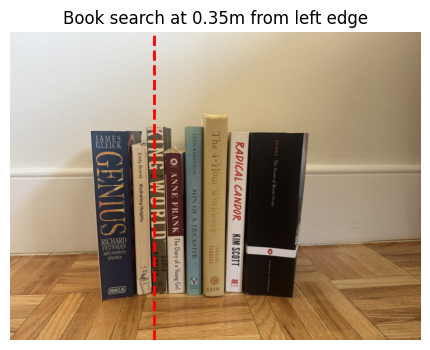

In [31]:
# Function to find a book at a specific location given a distance from the left edge
def find_book_at_location(distance_from_left, book_masks, book_info, rgb_img, shelf_width_meters=1.0):
    """
    Find which book is at a specific location on the shelf.
    
    Args:
        distance_from_left: Distance from the left edge of the shelf in meters
        book_masks: List of binary masks for each detected book
        book_info: List of book information strings
        rgb_img: The original RGB image
        shelf_width_meters: The actual width of the shelf in meters (default: 1.0m)
    
    Returns:
        The information about the book at that location, or a message if no book is found
    """
    if not book_masks or len(book_masks) == 0:
        return "No books detected"
    
    # Get image width in pixels
    img_height, img_width = rgb_img.shape[:2]
    
    # Convert the distance in meters to pixels
    distance_in_pixels = int(distance_from_left * img_width / shelf_width_meters)
    
    # Check if the distance is within the image bounds
    if distance_in_pixels < 0 or distance_in_pixels >= img_width:
        return f"Distance {distance_from_left}m is outside the shelf bounds (0-{shelf_width_meters}m)"
    
    # Find which book mask contains this pixel position
    # We'll check at multiple y-positions to improve reliability
    y_positions = [int(img_height * 0.5), int(img_height * 0.6), int(img_height * 0.7), int(img_height * 0.8)]
    
    book_counts = {}
    for y_position in y_positions:
        for i, mask in enumerate(book_masks):
            # Check if this position falls within the current book mask
            if y_position < mask.shape[0] and distance_in_pixels < mask.shape[1]:
                if mask[y_position, distance_in_pixels] > 0:
                    book_counts[i] = book_counts.get(i, 0) + 1
    
    # Find the book with the most overlaps
    found_book_idx = None
    max_count = 0
    for idx, count in book_counts.items():
        if count > max_count:
            max_count = count
            found_book_idx = idx
    
    if found_book_idx is not None:
        # Extract just the title from the book info
        book_title = book_info[found_book_idx].split('\n')[0] if '\n' in book_info[found_book_idx] else book_info[found_book_idx]
        return f"Book at {distance_from_left}m: {book_title}", book_title
    else:
        return f"No book found at position {distance_from_left}m"

# Example usage
test_distance = 0.35  # 35% from the left edge (0.35 meters if shelf is 1m wide)
result, book_title = find_book_at_location(test_distance, book_masks, book_info, rgb_img)
print(f"\nSearching for book at {test_distance}m from the left edge:")
print(result)

# Visualize the search position
plt.figure(figsize=(12, 4))
plt.imshow(rgb_img)
img_height, img_width = rgb_img.shape[:2]
search_x = int(test_distance * img_width)
plt.axvline(x=search_x, color='r', linestyle='--', linewidth=2)
plt.title(f"Book search at {test_distance}m from left edge")
plt.axis('off')
plt.show()


In [40]:
# Function to find similar books based on a selected book using natural language processing
def find_similar_books(book_title, book_info=None, top_n=1):
    """
    Find books similar to the selected book using natural language processing.
    
    Args:
        book_title: Title of the book to find recommendations for
        book_info: List of book information strings (optional)
        top_n: Number of similar books to return
    
    Returns:
        List of recommended book titles
    """
    import os
    from openai import OpenAI
    
    # Initialize the client with API key from environment
    client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))
    
    # If book_info is provided, create a list of all book titles
    available_books = []
    if book_info:
        all_titles = [book.split('\n')[0] if '\n' in book else book for book in book_info]
        # Remove the selected book from the list of potential recommendations
        available_books = [title for title in all_titles if title != book_title]
    
    # Create the prompt for the language model
    prompt = f"""
    A reader enjoyed the book "{book_title}". Based on this preference, which {top_n} books would they most likely enjoy next?
    """
    
    # Add available books to the prompt if provided
    if available_books:
        prompt += f"""
        Available books:
        {', '.join(available_books)}
        
        Please provide only the {top_n} most relevant recommendations in order of relevance, with a brief explanation for each.
        """
    
    # Make the API call using the new OpenAI API format
    response = client.chat.completions.create(
        model="gpt-4",
        messages=[
            {"role": "system", "content": "You are a knowledgeable librarian who provides thoughtful book recommendations."},
            {"role": "user", "content": prompt}
        ],
        temperature=0.7,
        max_tokens=500
    )
    
    # Extract the recommendations from the response (new API format)
    recommendations = response.choices[0].message.content.strip()
    
    return recommendations

# Extract the book index from the previous search result
print(f"\nRecommendations for '{book_title}'")

# Get similar books using natural language processing
recommendations = find_similar_books(book_title, book_info)
print(f'\nOn-shelf recommendations: {recommendations}')

recommendations = find_similar_books(book_title)
print(f'\nGeneral recommendations: {recommendations}')





Recommendations for 'KING OF THE WORLD, DAVID REMNICK'

On-shelf recommendations: 1. "GENIUS: RICHARD FEYNMAN AND MODERN PHYSICS, JAMES GLEICK": Given the reader's interest in "King of the World" by David Remnick, which is a biography exploring the life and career of Muhammad Ali, they are likely to enjoy another biography that delves into the life of an influential figure. "Genius: Richard Feynman and Modern Physics" by James Gleick provides an in-depth look at physicist Richard Feynman and his contributions to modern physics, offering a similarly engaging and insightful exploration of a notable individual and his impact.

General recommendations: Based on their interest in "King of the World" by David Remnick, the reader might enjoy "Muhammad Ali: His Life and Times" by Thomas Hauser. This book is another well-researched and engaging account of Muhammad Ali's life and career.


: 